In [260]:
import pandas as pd
import nltk
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [261]:
# torch gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [262]:
# use gpu if available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")
    

Using GPU


In [263]:
#Train
jan2017 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesJan2017.csv")
feb2017 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesFeb2017.csv")
march2017 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesMarch2017.csv")
april2017 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesApril2017.csv")
may2017 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesMay2017.csv")


jan2018 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesJan2018.csv")
feb2018 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesFeb2018.csv")
march2018 = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesMarch2018.csv")



#Test
test_data = pd.read_csv("/home/abhinawap/StudySes/OTI/ArticlesApril2018.csv")

## **Preprocessing**

In [264]:
train_data = pd.concat([jan2017, feb2017, march2017, april2017, may2017, jan2018, feb2018, march2018], ignore_index=True)

In [265]:
train_data.head()

,articleID,abstract,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,58691a5795d0e039260788b9,NaN,By JENNIFER STEINHAUER,article,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",1,National,1,2017-01-01 15:03:38,Politics,The most powerful and ambitious Republican-led...,The New York Times,News,https://www.nytimes.com/2017/01/01/us/politics...,1324
1,586967bf95d0e03926078915,NaN,By MARK LANDLER,article,Fractured World Tested the Hope of a Young Pre...,"['Obama, Barack', 'Afghanistan', 'United State...",1,Foreign,1,2017-01-01 20:34:00,Asia Pacific,A strategy that went from a “good war” to the ...,The New York Times,News,https://www.nytimes.com/2017/01/01/world/asia/...,2836
2,58698a1095d0e0392607894a,NaN,By CAITLIN LOVINGER,article,Little Troublemakers,"['Crossword Puzzles', 'Boxing Day', 'Holidays ...",1,Games,0,2017-01-01 23:00:24,Unknown,Chuck Deodene puts us in a bubbly mood.,The New York Times,News,https://www.nytimes.com/2017/01/01/crosswords/...,445
3,5869911a95d0e0392607894e,NaN,By JOCHEN BITTNER,article,"Angela Merkel, Russia’s Next Target","['Cyberwarfare and Defense', 'Presidential Ele...",1,OpEd,15,2017-01-01 23:30:27,Unknown,"With a friend entering the White House, Vladim...",The New York Times,Op-Ed,https://www.nytimes.com/2017/01/01/opinion/ang...,864
4,5869a61795d0e03926078962,NaN,By JIAYIN SHEN,article,Boots for a Stranger on a Bus,"['Shoes and Boots', 'Buses', 'New York City']",0,Metro,12,2017-01-02 01:00:02,Unknown,Witnessing an act of generosity on a rainy day.,The New York Times,Brief,https://www.nytimes.com/2017/01/01/nyregion/me...,309


In [266]:
train_data.isnull().sum()

articleID              0
abstract            7844
byline                 0
documentType           0
headline               0
keywords               0
multimedia             0
newDesk                0
printPage              0
pubDate                0
sectionName            0
snippet                0
source                 0
typeOfMaterial         0
webURL                 0
articleWordCount       0
dtype: int64

In [267]:
# Select headline, keywords and newDesk columns
train_data = train_data[['headline', 'keywords', 'newDesk']]
test_data = test_data[['headline', 'keywords', 'newDesk']]

In [268]:
train_data.shape

(8011, 3)

In [269]:
# Treat "Unknown" as missing values
train_data.replace(['Unknown', '[]'], np.nan, inplace=True)
test_data.replace(['Unknown', '[]'], np.nan, inplace=True)

In [270]:
# Drop missing values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Drop duplicates
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

In [271]:
test_data.shape

(1148, 3)

In [272]:
train_data.head()

,headline,keywords,newDesk
0,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",National
1,Fractured World Tested the Hope of a Young Pre...,"['Obama, Barack', 'Afghanistan', 'United State...",Foreign
2,Little Troublemakers,"['Crossword Puzzles', 'Boxing Day', 'Holidays ...",Games
3,"Angela Merkel, Russia’s Next Target","['Cyberwarfare and Defense', 'Presidential Ele...",OpEd
4,Boots for a Stranger on a Bus,"['Shoes and Boots', 'Buses', 'New York City']",Metro


In [273]:
test_data.head()

,headline,keywords,newDesk
0,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",Sports
1,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",Climate
2,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",Dining
8,How a Bag of Texas Dirt Became a Times Tradition,"['Texas', 'Soil', 'Pregnancy and Childbirth', ...",Insider
10,Commuter Reprogramming,"['Bicycles and Bicycling', 'Google Maps', 'Com...",Magazine


In [274]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6816 entries, 0 to 8010
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  6816 non-null   object
 1   keywords  6816 non-null   object
 2   newDesk   6816 non-null   object
dtypes: object(3)
memory usage: 213.0+ KB


In [275]:
train_data['newDesk'].value_counts()

newDesk
OpEd               1406
National            476
Culture             399
Metro               394
Foreign             388
Magazine            312
Dining              312
Business            311
Sports              296
Editorial           287
Games               267
Washington          264
Well                263
Science             238
Upshot              203
RealEstate          157
Insider             135
Weekend             114
Learning            105
Travel               94
Arts&Leisure         54
SundayBusiness       49
Metropolitan         44
Styles               40
BookReview           37
Photo                25
NewsDesk             19
Investigative        18
Climate              17
Obits                15
SpecialSections      15
TStyle               12
Smarter Living       11
EdLife               11
Politics              7
Express               6
Letters               5
Video                 3
Summary               3
Society               2
Automobiles           1
NYTNow  

In [276]:
train_data['newDesk'].unique()

array(['National', 'Foreign', 'Games', 'OpEd', 'Metro', 'Sports',
       'Culture', 'Editorial', 'Science', 'Upshot', 'Magazine',
       'Business', 'SundayBusiness', 'RealEstate', 'Well', 'Dining',
       'Styles', 'Insider', 'Learning', 'Weekend', 'BookReview', 'Travel',
       'Metropolitan', 'Politics', 'EdLife', 'Letters', 'Arts&Leisure',
       'SpecialSections', 'Investigative', 'NewsDesk', 'Summary',
       'Automobiles', 'Society', 'Washington', 'Smarter Living',
       'Climate', 'Obits', 'Express', 'Video', 'TStyle', 'Photo',
       'NYTNow'], dtype=object)

### **Binning Target Label**

In [277]:
# bin the newDesk column
def bin_newDesk(newDesk):
    if newDesk in ['National', 'Foreign', 'Politics', 'Washington', 'Investigative', 'Metro', 'NewsDesk', 'Express', 'NYTNow', 'Metropolitan']:
        return 'News'
    elif newDesk in ['Sports', 'Games', 'Travel', 'BookReview']:
        return 'Entertainment'
    elif newDesk in ['Culture', 'Arts&Leisure', 'TStyle', 'Letters', 'Photo']:
        return 'Arts&Culture'
    elif newDesk in ['Business', 'SundayBusiness', 'RealEstate', 'Automobiles']:
        return 'Business'
    elif newDesk in ['Science', 'Climate']:
        return 'Science&Climates'
    elif newDesk in ['Smarter Living', 'Well', 'Styles', 'Society']:
        return 'Lifestyle'
    elif newDesk in ['OpEd', 'Editorial']:
        return 'Opinion'
    elif newDesk in ['Dining', 'Magazine', 'Weekend']:
        return 'Leisure'
    elif newDesk in ['SpecialSections', 'Summary', 'Upshot']:
        return 'SpecialSections'
    elif newDesk in ['Learning', 'EdLife']:
        return 'Education'
    elif newDesk in ['Video', 'Photo', 'Insider']:
        return 'Media'
    elif newDesk in ['Obits']:
        return 'Obits'

In [278]:
# Apply the function to the newDesk column
train_data['newDesk'] = train_data['newDesk'].apply(bin_newDesk)
test_data['newDesk'] = test_data['newDesk'].apply(bin_newDesk)

In [279]:
train_data['newDesk'].value_counts()

newDesk
Opinion             1693
News                1617
Leisure              738
Entertainment        694
Business             518
Arts&Culture         495
Lifestyle            316
Science&Climates     255
SpecialSections      221
Media                138
Education            116
Obits                 15
Name: count, dtype: int64

In [280]:
train_data.isnull().sum()

headline    0
keywords    0
newDesk     0
dtype: int64

### **Label Encode**
To label encode we make two dictionaries namely id2label and label2id. The label2id is used for mapping the label into integers on the dataframe by assigning the label as the key and a number as the value. While, id2label is used for translating the encoded labels back to its original form by assigning the number as the key and the label.

In [281]:
# Ensure newDesk column is cleaned (lowercase and stripped of extra spaces)
train_data['newDesk'] = train_data['newDesk'].str.lower().str.strip()
test_data['newDesk'] = test_data['newDesk'].str.lower().str.strip()

# Get unique labels from the cleaned training data
labels = train_data['newDesk'].unique()

# Create id2label and label2id dictionaries
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

In [282]:
print(label2id)

{'news': 0, 'entertainment': 1, 'opinion': 2, 'arts&culture': 3, 'science&climates': 4, 'specialsections': 5, 'leisure': 6, 'business': 7, 'lifestyle': 8, 'media': 9, 'education': 10, 'obits': 11}


In [283]:
print(id2label)

{0: 'news', 1: 'entertainment', 2: 'opinion', 3: 'arts&culture', 4: 'science&climates', 5: 'specialsections', 6: 'leisure', 7: 'business', 8: 'lifestyle', 9: 'media', 10: 'education', 11: 'obits'}


In [284]:
train_data.head()

,headline,keywords,newDesk
0,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",news
1,Fractured World Tested the Hope of a Young Pre...,"['Obama, Barack', 'Afghanistan', 'United State...",news
2,Little Troublemakers,"['Crossword Puzzles', 'Boxing Day', 'Holidays ...",entertainment
3,"Angela Merkel, Russia’s Next Target","['Cyberwarfare and Defense', 'Presidential Ele...",opinion
4,Boots for a Stranger on a Bus,"['Shoes and Boots', 'Buses', 'New York City']",news


In [285]:
test_data.head()

,headline,keywords,newDesk
0,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",entertainment
1,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",science&climates
2,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",leisure
8,How a Bag of Texas Dirt Became a Times Tradition,"['Texas', 'Soil', 'Pregnancy and Childbirth', ...",media
10,Commuter Reprogramming,"['Bicycles and Bicycling', 'Google Maps', 'Com...",leisure


In [286]:
test_data.reset_index(drop=True, inplace=True)

test_data_labels = test_data['newDesk']
test_data = test_data.drop(columns='newDesk')

In [287]:
test_data_labels.head()

0       entertainment
1    science&climates
2             leisure
3               media
4             leisure
Name: newDesk, dtype: object

In [288]:
train_data['newDesk'].value_counts()

newDesk
opinion             1693
news                1617
leisure              738
entertainment        694
business             518
arts&culture         495
lifestyle            316
science&climates     255
specialsections      221
media                138
education            116
obits                 15
Name: count, dtype: int64

In [289]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6816 entries, 0 to 8010
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  6816 non-null   object
 1   keywords  6816 non-null   object
 2   newDesk   6816 non-null   object
dtypes: object(3)
memory usage: 213.0+ KB


### **Clean the text**

In [290]:
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Clean text function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text
# Function to preprocess data for BERT with two text columns
def preprocess_data(examples):
    # Extract text columns
    headlines = examples['headline']
    keywords = examples['keywords']
    
    # Clean text
    headlines = headlines.apply(clean_text)
    keywords = keywords.apply(clean_text)
    
    # Concatenate text columns
    text = headlines + ' ' + keywords
    text = text.tolist()
    
    examples['text'] = text
    examples = examples.drop(columns=['headline', 'keywords'])
    
    return examples

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abhinawap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abhinawap/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## **Data Preprocessing**

In [291]:
from sklearn.model_selection import train_test_split

X = train_data[['headline', 'keywords']]
y = train_data['newDesk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [292]:
# reset index
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
test_data_labels.reset_index(drop=True, inplace=True)

In [293]:
# preprocess data
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)
X_val = preprocess_data(X_val)
test_data = preprocess_data(test_data)

# Map labels to integers
y_train = y_train.map(label2id)
y_val = y_val.map(label2id)
y_test = y_test.map(label2id)
test_data_labels = test_data_labels.map(label2id)

# **EDA**

In [294]:
X_train_eda = X_train.copy()

Text(0, 0.5, 'Count')

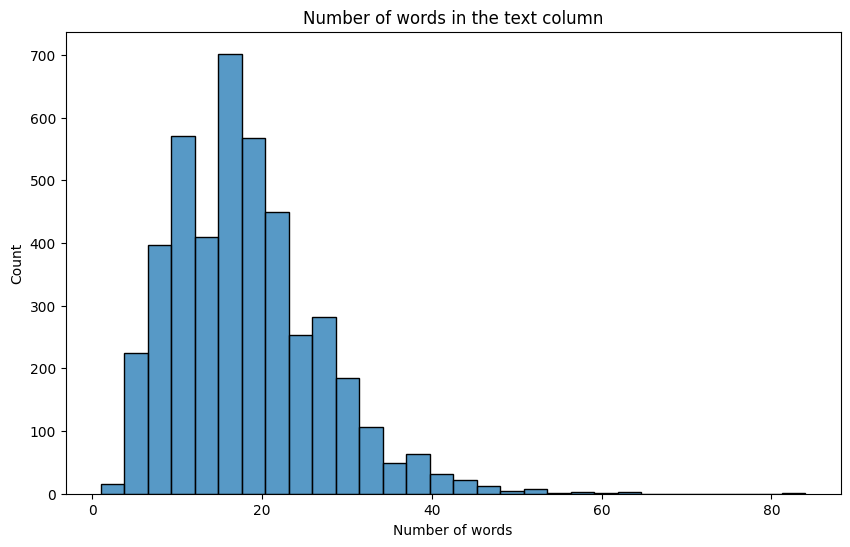

In [295]:
# Histogram of the number of words in the text column
plt.figure(figsize=(10, 6))
sns.histplot(X_train_eda['text'].apply(lambda x: len(x.split())), bins=30)
plt.title('Number of words in the text column')
plt.xlabel('Number of words')
plt.ylabel('Count')

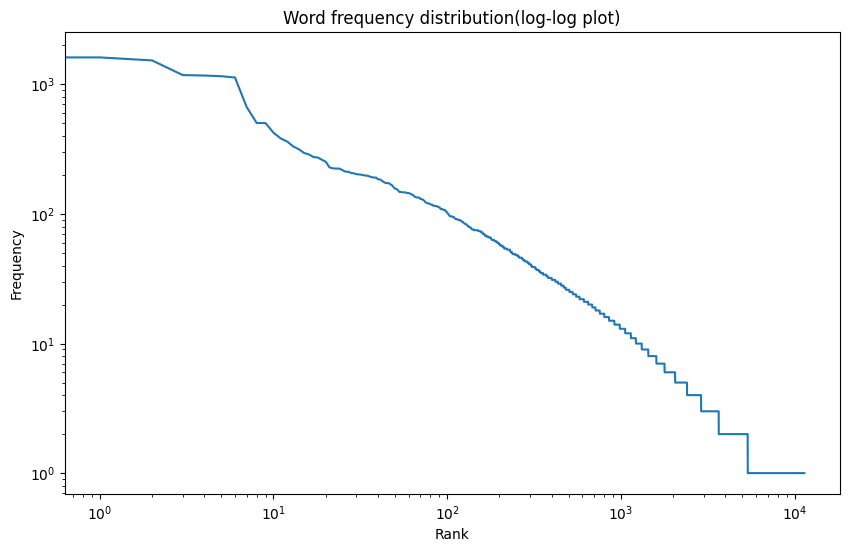

In [296]:
# Word frequency distribution log-log plot
from collections import Counter

# Tokenize text
words = X_train_eda['text'].str.split().sum()

# Count word frequency
word_freq = Counter(words)

# Sort word frequency
word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

# Plot word frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(list(word_freq.values()))
plt.yscale('log')
plt.xscale('log')
plt.title('Word frequency distribution(log-log plot)')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()



Text(0, 0.5, 'Count')

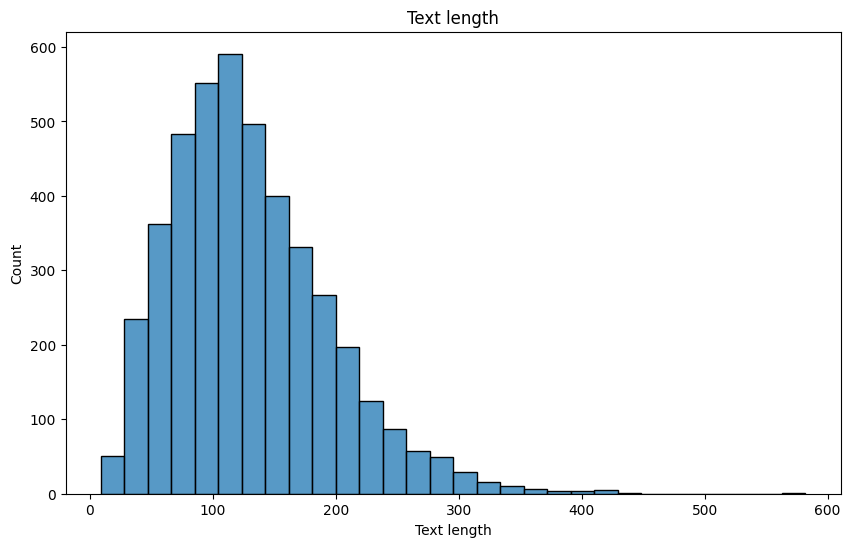

In [297]:
# Histogram for text length in characters
plt.figure(figsize=(10, 6))
sns.histplot(X_train_eda['text'].apply(len), bins=30)
plt.title('Text length')
plt.xlabel('Text length')
plt.ylabel('Count')

## **Tokenize and Data Loading**

In [298]:
# tokenize text
X_train_tokenized = tokenizer(X_train['text'].tolist(), truncation=True, padding=True)
X_test_tokenized = tokenizer(X_test['text'].tolist(), truncation=True, padding=True)
X_val_tokenized = tokenizer(X_val['text'].tolist(), truncation=True, padding=True)
test_data_tokenized = tokenizer(test_data['text'].tolist(), truncation=True, padding=True)

In [299]:
from torch.utils.data import DataLoader, Dataset

class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [300]:
train_dataloader = DataLoader(X_train_tokenized, y_train)
test_dataloader = DataLoader(X_test_tokenized, y_test)
val_dataloader = DataLoader(X_val_tokenized, y_val)
test_data_dataloader = DataLoader(test_data_tokenized, test_data_labels)

# **Modelling**

In [301]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [302]:
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [303]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True,
    learning_rate=0.00005,
    metric_for_best_model='F1',
    greater_is_better=True,
)

/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [304]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [305]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.272100,1.944604,0.298808,0.101328,0.256502,0.126633
100,1.754100,1.414908,0.571952,0.371893,0.466169,0.388225
150,1.356600,1.206980,0.570119,0.438872,0.463766,0.459164
200,1.182300,1.167546,0.605866,0.456987,0.487136,0.474161
250,1.214800,0.981416,0.690192,0.538241,0.568687,0.536021
300,0.974900,0.942168,0.709441,0.545360,0.555465,0.543479
350,0.826400,0.924970,0.714940,0.552656,0.607648,0.543531
400,0.794700,0.909676,0.722273,0.572630,0.607852,0.558221
450,0.778800,0.919966,0.703941,0.562817,0.583184,0.558274
500,0.824200,0.897421,0.731439,0.565057,0.610446,0.552881


/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

TrainOutput(global_step=1365, training_loss=0.6520721075735686, metrics={'train_runtime': 177.5807, 'train_samples_per_second': 122.789, 'train_steps_per_second': 7.687, 'total_flos': 1143047794921200.0, 'train_loss': 0.6520721075735686, 'epoch': 5.0})

## **Evaluation**

In [313]:
trainer.evaluate()

/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9526429772377014,
 'eval_Accuracy': 0.7561869844179652,
 'eval_F1': 0.6015050555189182,
 'eval_Precision': 0.6084994258349439,
 'eval_Recall': 0.6078335938153394,
 'eval_runtime': 1.2704,
 'eval_samples_per_second': 858.765,
 'eval_steps_per_second': 27.55,
 'epoch': 5.0}

In [307]:
# predict on test set
predictions = trainer.predict(test_dataloader)

# Compute metrics
metrics = compute_metrics(predictions)

# Print the computed metrics
print(metrics)

/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.7265395894428153, 'F1': 0.5891299740991144, 'Precision': 0.5926041329966454, 'Recall': 0.5940090489062061}


/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [308]:
class_names = list(label2id.keys())

preds = predictions.predictions.argmax(-1)

labels = predictions.label_ids

# Print classification report
print(classification_report(labels, preds, target_names=class_names))

                  precision    recall  f1-score   support

            news       0.76      0.84      0.80       335
   entertainment       0.82      0.93      0.87       128
         opinion       0.82      0.72      0.77       348
    arts&culture       0.67      0.86      0.75        97
science&climates       0.49      0.41      0.45        46
 specialsections       0.38      0.51      0.44        39
         leisure       0.65      0.62      0.64       143
        business       0.76      0.62      0.68       107
       lifestyle       0.65      0.55      0.60        71
           media       0.36      0.28      0.31        29
       education       0.75      0.79      0.77        19
           obits       0.00      0.00      0.00         2

        accuracy                           0.73      1364
       macro avg       0.59      0.59      0.59      1364
    weighted avg       0.73      0.73      0.72      1364



/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [309]:
# Predict on test data
predictions = trainer.predict(test_data_dataloader)


/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [310]:
# Compute metrics
metrics = compute_metrics(predictions)

# Print the computed metrics
print(metrics)

{'Accuracy': 0.7369337979094077, 'F1': 0.575240868457139, 'Precision': 0.5907477258404308, 'Recall': 0.6019209027546755}


/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [311]:
# Extract predicted class labels
preds = predictions.predictions.argmax(-1)

# Extract true class labels
true_labels = predictions.label_ids

# Print classification report
print(classification_report(true_labels, preds, target_names=class_names))

                  precision    recall  f1-score   support

            news       0.78      0.86      0.82       345
   entertainment       0.88      0.90      0.89        94
         opinion       0.74      0.75      0.74       217
    arts&culture       0.74      0.88      0.81       123
science&climates       0.46      0.41      0.44        41
 specialsections       0.36      0.45      0.40        20
         leisure       0.55      0.49      0.52        96
        business       0.80      0.69      0.74       123
       lifestyle       0.81      0.41      0.54        71
           media       0.60      0.38      0.46         8
       education       0.38      1.00      0.55         3
           obits       0.00      0.00      0.00         7

        accuracy                           0.74      1148
       macro avg       0.59      0.60      0.58      1148
    weighted avg       0.73      0.74      0.73      1148



/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abhinawap/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

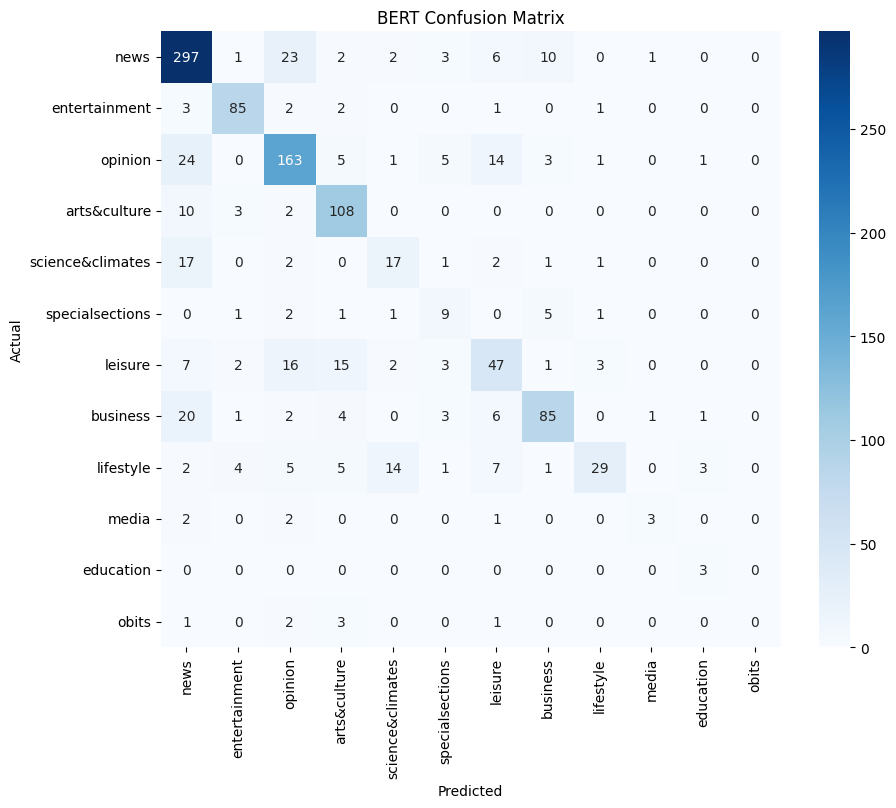

In [312]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()